# 신경망의 수학적 구성 요소 (PyTorch)

이 노트북은 PyTorch를 사용하여 신경망의 기본 구성 요소를 시연합니다. MNIST 데이터셋을 사용하여 간단한 신경망을 구축하고 훈련합니다.

## PyTorch와 기타 라이브러리 불러오기

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

## MNIST 데이터셋 불러오기

In [2]:
# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.ToTensor(),
])

# MNIST 데이터셋 다운로드 및 로드
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

- 훈련셋과 테스트셋에 각각 6만개와 1만개의 샘플과 타깃이 포함됨.

In [3]:
print(f"학습 데이터셋 크기: {len(train_dataset)}")
print(f"테스트 데이터셋 크기: {len(test_dataset)}")

학습 데이터셋 크기: 60000
테스트 데이터셋 크기: 10000


- 픽셀값이 이미 0과 1 사의 부동소수점으로 변환되었음.

In [4]:
# train_dataset의 첫 번째 항목 확인
image, label = train_dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")
print(f"Image max value: {image.max()}, min value: {image.min()}")


Image shape: torch.Size([1, 28, 28]), Label: 5
Image max value: 1.0, min value: 0.0


- 훈련셋 첫째 샘플 내용 확인

Image Tensor Shape: torch.Size([1, 28, 28])
Image Tensor Type: torch.float32
Label: 5


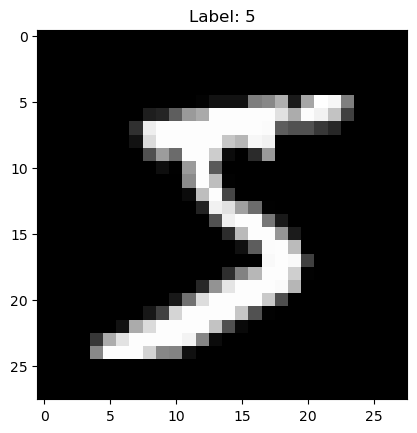

In [5]:
# train_dataset의 첫 번째 항목 확인
image, label = train_dataset[0]

# 이미지 텐서의 정보 출력
print("Image Tensor Shape:", image.shape)
print("Image Tensor Type:", image.dtype)
print("Label:", label)

# 이미지 시각화
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.show()

DataLoader 객체 생성: 
- 데이터셋(Dataset)을 모델에 효율적으로 공급하기 위한 핵심 유틸리티
- Dataset이 전체 데이터를 보관하는 창고라면, DataLoader는 그 창고에서 물건(데이터)을 꺼내 컨베이어 벨트(학습 루프)에 올려주는 역할 수행

In [6]:
# 데이터 로더 생성
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

## 모델 선언

- 2개의 Dense 층으로 구성된 모델 구성
- 손실함수, 옵티마이저 지정

In [7]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# 장치 설정: CPU 또는 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN().to(device)

print(f"Device: {device}")
print("신경망 모델 정의 완료:")
print(model)

Device: cuda
신경망 모델 정의 완료:
SimpleNN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax(dim=1)
)


- 손실함수와 옵티마이저 지정

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"손실 함수: {criterion}")
print(f"옵티마이저: {optimizer}")

손실 함수: CrossEntropyLoss()
옵티마이저: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## 모델 훈련

- 에포크: 5
- 옵티마이저 초기화, 순전파, 역전파 및 가중치 업데이트 지정

In [9]:
epochs = 5
for epoch in range(epochs):
    running_loss = 0
    correct_count, all_count = 0, 0
    
    model.train() # 모델을 훈련 모드로 설정
    
    for images, labels in train_loader:
        # 데이터를 설정된 장치로 이동
        images, labels = images.to(device), labels.to(device)

        # 옵티마이저 그레이디언트 초기화
        optimizer.zero_grad()
        
        # 순전파
        output = model(images)
        loss = criterion(output, labels)
        
        # 역전파
        loss.backward()
        # 옵티마이저 가중치 업데이트
        optimizer.step()
        
        running_loss += loss.item()
        
        # 정확도 계산
        _, predicted = torch.max(output.data, 1)
        all_count += labels.size(0)
        correct_count += (predicted == labels).sum().item()

    # 에포크 종료 시 손실값과 정확도 출력
    train_accuracy = (correct_count / all_count) * 100
    print(f"Epoch {epoch+1}/{epochs} - 훈련 손실: {running_loss/len(train_loader):.4f}, 훈련 정확도: {train_accuracy:.2f}%")

print("\n모델 훈련 완료.")

Epoch 1/5 - 훈련 손실: 0.3200, 훈련 정확도: 91.02%
Epoch 2/5 - 훈련 손실: 0.1282, 훈련 정확도: 96.35%
Epoch 3/5 - 훈련 손실: 0.0843, 훈련 정확도: 97.54%
Epoch 4/5 - 훈련 손실: 0.0597, 훈련 정확도: 98.23%
Epoch 5/5 - 훈련 손실: 0.0451, 훈련 정확도: 98.65%

모델 훈련 완료.


- 테스트셋을 이용하여 훈련된 모델 평가

In [10]:
correct_count, all_count = 0, 0
model.eval() # 모델을 평가 모드로 설정

with torch.no_grad(): # 그래디언트 계산 비활성화
    for images, labels in test_loader:
        # 데이터를 설정된 장치로 이동
        images, labels = images.to(device), labels.to(device)
        
        # 순전파
        outputs = model(images)
        
        # 예측
        _, predicted = torch.max(outputs.data, 1)
        
        # 정확도 계산
        all_count += labels.size(0)
        correct_count += (predicted == labels).sum().item()

print(f"전체 테스트 이미지 수: {all_count}")
print(f"정확도: {(correct_count/all_count)*100:.2f}%")

전체 테스트 이미지 수: 10000
정확도: 97.86%


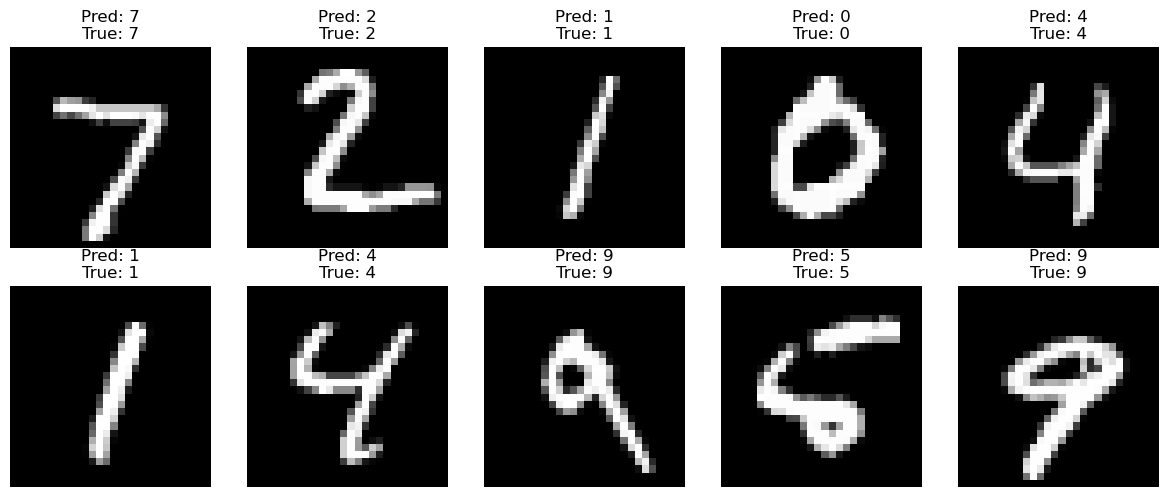

In [11]:
# 테스트 데이터셋에서 이미지 몇 개 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 예측을 위해 이미지를 모델과 동일한 장치로 이동
images_on_device = images.to(device)

# 예측 수행
with torch.no_grad():
    outputs = model(images_on_device)

# 시각화를 위해 CPU로 다시 이동
outputs = outputs.to('cpu')

# 예측 결과 및 실제 레이블 시각화
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    # 이미지 표시 (원본 CPU 텐서 사용)
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    
    # 예측 레이블 찾기
    _, predicted = torch.max(outputs[i], 0)
    
    # 제목 설정
    ax.set_title(f"Pred: {predicted.item()}\nTrue: {labels[i].item()}")
    
    # 축 정보 숨기기
    ax.axis('off')

plt.tight_layout()
plt.show()